<a href="https://colab.research.google.com/github/vonvolous/d2l/blob/main/code/D2l_11_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transformer Architecture

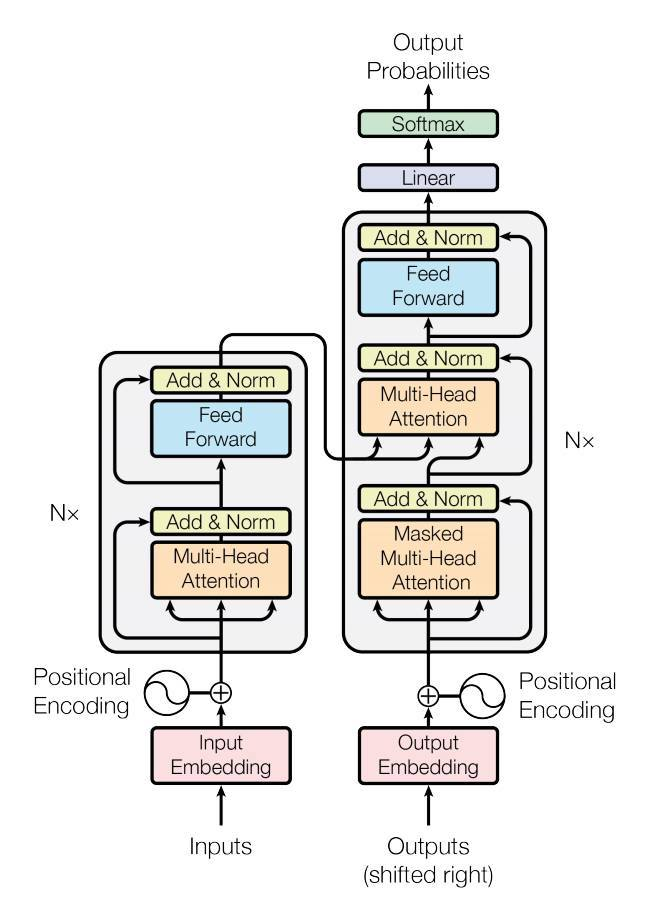

* 왼쪽 블록 : 인코더
* 오른쪽 블록 : 디코더

* pytorch에서 제공하는 nn.Transformer는 전체 구조에서 멀티헤드 어텐션과 피드 포워드를 처리함
* 따라서 Linear, Positional Encoding, Embedding 등은 따로 구현해줘야 함!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import pandas as pd
import random
import re

from torch.utils.data import DataLoader, Dataset

기본 transformer 구조

```python
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, ):
        super().__init__()

        # Layers
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )

    def forward(self):
        pass
```

* d_model : 트랜스포머의 인코더와 디코더의 정해진 입력과 출력 크기(default=512)
* num_encoder_layers : 트랜스포머 모델에 인코더가 몇 층으로 구성되어 있는지를 의미(default=6)
* num_decoder_layers : 디코더의 층 수(default=6)
* nhead : 멀티헤드 어텐션 모델의 헤드 수(default=8)
* dim_feedforward : feedforward network model의 차원, 피드 포워드 신경망 은닉층의 크기(default=2048)

Positional Encoding
* 트랜스포머는 입력 시퀀스의 순서에 신경쓰지 않으므로 순서 정보를 주입하기 위해 이 방법을 사용
* **위치에 따라 중요도를 부여**하는 방식
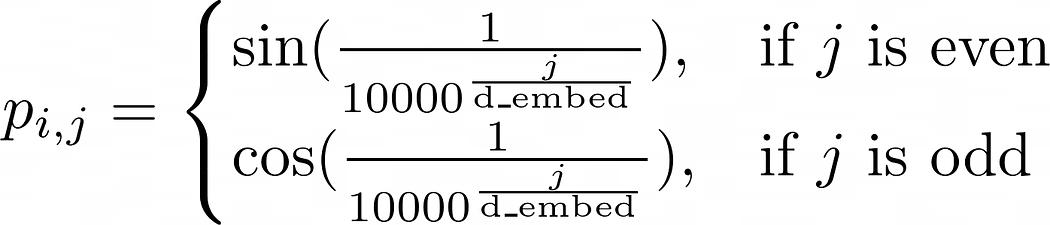

In [7]:
torch.arange(0, 6, dtype=torch.float).view(-1, 1)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.]])

In [ ]:
torch.exp(torch.arange(0, dim_model, 2))

In [11]:
math.log(10000.0) # math.log(x, [, base]) : base 따로 지정 안하면 e로 설정

9.210340371976184

* transpose(x, y) : 딱 두 개의 차원을 맞교환할 수 있음
* permute() : 모든 차원들을 맞교환할 수 있음

```python
x = torch.rand(16, 32, 3)
y = x.transpose(0, 2) # [3, 32, 16]
z = x.permute(2, 1, 0) # [3, 32, 16]
```

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - from formula, num_encoder_layers==6이므로 max_len==6!
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 10000^(2i/dim_model)
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding", pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos_encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])


Transformer 모델 구현
* Target Masking
    * 모델 구조 중 Masked Multi-Head Attention이라는 특수 블록 존재
    * masking tensor는 시퀀스의 모든 element에 대해 하나 이상의 element를 모델에 표시해 특정 크기로 구성됨
    * 이 행렬을 target vector에 추가해 행렬은 트랜스포머가 elements를 액세스 할 수 있을 땐0, 액세스할 수 없으면 inf로 구성

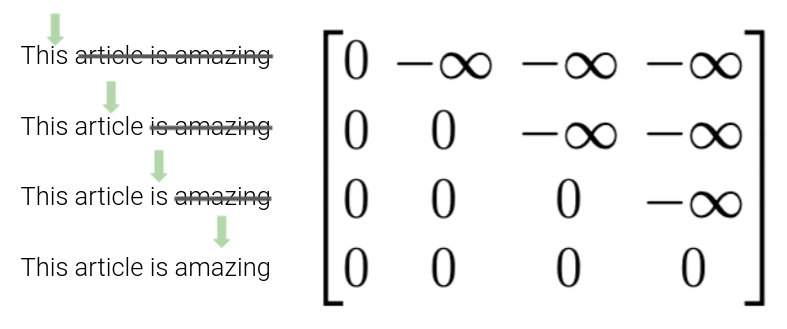
* Padding Masking
    * 텐서는 GPU에 저장할 수 있는 행렬이므로 모든 차원이 같은 크기의 요소를 가져야 함
    * 그래서 특수 토큰을 이용해 시작이나 문장 끝 등의 나머지 공간을 채우기 위해 이 방법 사용

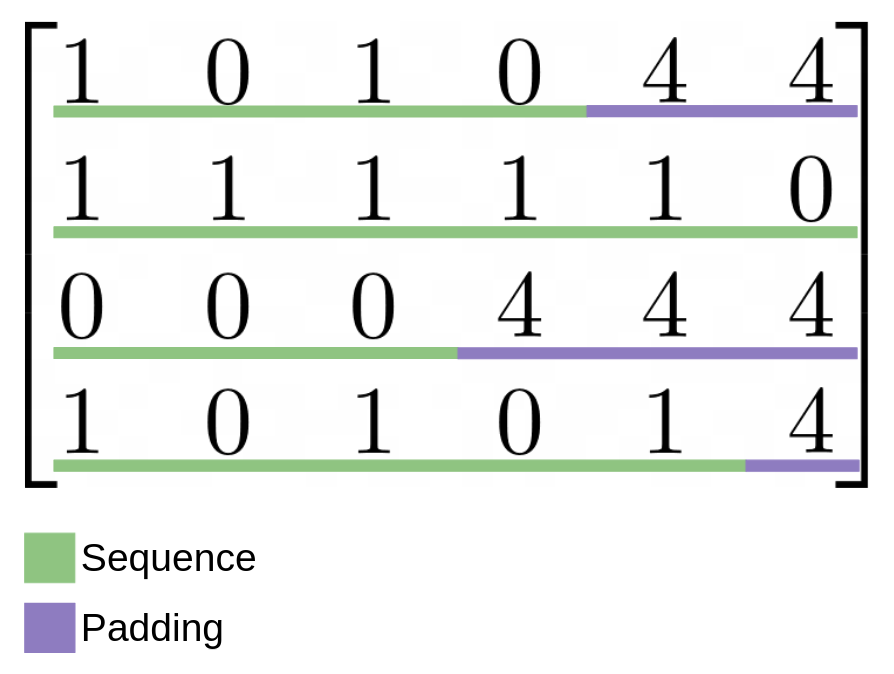

In [20]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p):
        super().__init__()

        # info
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # layers
        self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=5000)
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # src, tgt 사이즈는 반드시 (batch_size, src sequence length)여야 함

        # embedding + positional encoding - out size = (bach_size, sequence length, dim_model)
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)

        # transformer blocks - out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask,
                                           src_key_padding_mask=src_pad_mask,
                                           tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)

### Load Dataset

In [15]:
def generate_random_data(n):
    SOS_token = np.array([2])
    EOS_token = np.array([3])
    length = 8

    data = []

    # 1, 1, 1, 1, 1, 1 -> 1, 1, 1, 1, 1
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.ones(length), EOS_token))
        y = np.concatenate((SOS_token, np.ones(length), EOS_token))
        data.append([X, y])

    # 0, 0, 0, 0 -> 0, 0, 0, 0
    for i in range(n // 3):
        X = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        y = np.concatenate((SOS_token, np.zeros(length), EOS_token))
        data.append([X, y])

    # 1, 0, 1, 0 -> 1, 0, 1, 0, 1
    for i in range(n // 3):
        X = np.zeros(length)
        start = random.randint(0, 1)

        X[start::2] = 1

        y = np.zeros(length)
        if X[-1] == 0:
            y[::2] = 1
        else :
            y[1::2] = 1

        X = np.concatenate((SOS_token, X, EOS_token))
        y = np.concatenate((SOS_token, y, EOS_token))
        data.append([X, y])

    np.random.shuffle(data)

    return data

# 크기가 16인 배치 형태로 만듦
def batchify_data(data, batch_size=16, padding=False, padding_token=-1):
    batches = []
    for idx in range(0, len(data), batch_size):
        # batch_size 크기가 아닌 경우 마지막 비트를 얻지 않도록 함
        if idx + batch_size < len(data):
            # 여기서 배치 최대 길이를 가져와 PAD 토큰으로 길이를 정규화해야함
            if padding:
                max_batch_length = 0
                # batch에서 가장 긴 문장 가져오기
                for seq in data[idx : idx + batch_size]:
                    if len(seq) > max_batch_length:
                        max_batch_length = len(seq)

                # 최대 길이에 도달할 때까지 X 패딩 토큰을 추가
                for seq_idx in range(batch_size):
                    remaining_length = max_batch_length - len(data[idx + seq_idx])
                    data[idx + seq_idx] += [padding_token] * remaining_length

            batches.append(np.array(data[idx : idx + batch_size]).astype(np.int64))
            print(f"{len(batches)} batches of size {batch_size}")

            return batches

In [16]:
train_data = generate_random_data(9000)
val_data = generate_random_data(3000)

train_dataloader = batchify_data(train_data)
val_dataloader = batchify_data(val_data)

1 batches of size 16
1 batches of size 16


### Training & Validation

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_tokens=4, dim_model=8, num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [24]:
def train(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0

    for batch in dataloader:
        X, y = batch[:, 0], batch[:, 1]
        X, y = torch.tensor(X).to(device), torch.tensor(y).to(device)

        # 이제 tgt를 1만큼 이동해 <SOS>를 사용하여 pos 1에서 토큰을 예측
        y_input = y[:, :-1]
        y_expected = y[:, 1:]

        # 다음 단어를 마스킹하려면 마스크 가져오기
        sequence_length = y_input.size(1)
        tgt_mask = model.get_tgt_mask(sequence_length).to(device)

        # X, y_input 및 tgt_mask를 전달해 표준 training
        pred = model(X, y_input, tgt_mask)

        # permute을 수행해 batch size가 처음이 되도록
        pred = pred.permute(1, 2, 0)
        loss = loss_fn(pred, y_expected)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.detach().item()

    return total_loss / len(dataloader)

def validation(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch[:, 0], batch[:, 1]
            X, y = torch.tensor(X, dtype=torch.long, device=device), torch.tensor(y, dtype=torch.long, device=device)

            y_input = y[:, :-1]
            y_expected = y[:, 1:]

            sequence_length = y_input.size(1)
            tgt_mask = model.get_tgt_mask(sequence_length).to(device)

            pred = model(X, y_input, tgt_mask)

            pred = pred.permute(1, 2, 0)
            loss = loss_fn(pred, y_expected)
            total_loss += loss.detach().item()

        return total_loss / len(dataloader)

def fit(model, opt, loss_fn, train_dataloader, val_dataloader, epochs):
    # 나중에 plotting 하기 위해
    train_loss_list, validation_loss_list = [], []

    print("Training and Validating Model...")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}/{epochs}", "-"*25)

        train_loss = train(model, opt, loss_fn, train_dataloader)
        train_loss_list += [train_loss]
        validation_loss = validation(model, loss_fn, val_dataloader)
        validation_loss_list += [validation_loss]

        print(f"Training loss: {train_loss:.4f}")
        print(f"Validation loss: {validation_loss: .4f}")
        print()

    return train_loss_list, validation_loss_list

In [25]:
train_loss_list, validation_loss_list = fit(model, opt, loss_fn, train_dataloader, val_dataloader, 5)

Training and Validating Model...
------------------------- Epoch 1/5 -------------------------
Training loss: 1.5426
Validation loss:  1.3517

------------------------- Epoch 2/5 -------------------------
Training loss: 1.3566
Validation loss:  1.2493

------------------------- Epoch 3/5 -------------------------
Training loss: 1.2790
Validation loss:  1.1927

------------------------- Epoch 4/5 -------------------------
Training loss: 1.1912
Validation loss:  1.1615

------------------------- Epoch 5/5 -------------------------
Training loss: 1.1547
Validation loss:  1.1386



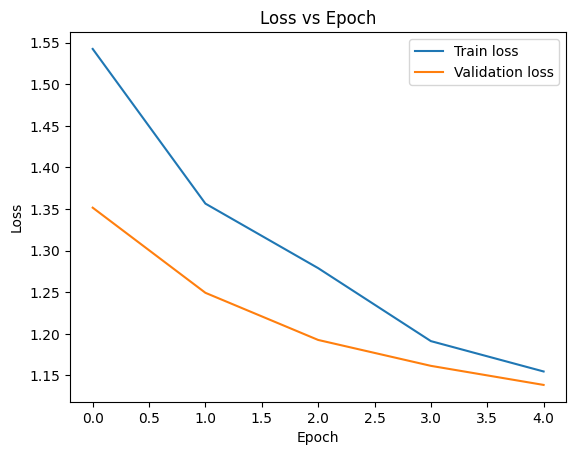

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label = "Train loss")
plt.plot(validation_loss_list, label = "Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()